# Fetal Health Analysis
This notebook performs preprocessing, feature selection, and machine learning implementation.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Step 1: Load Dataset

In [42]:
df = pd.read_csv('fetal_health.csv')
df.head(), df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

(   baseline value  accelerations  fetal_movement  uterine_contractions  \
 0           120.0          0.000             0.0                 0.000   
 1           132.0          0.006             0.0                 0.006   
 2           133.0          0.003             0.0                 0.008   
 3           134.0          0.003             0.0                 0.008   
 4           132.0          0.007             0.0                 0.008   
 
    light_decelerations  severe_decelerations  prolongued_decelerations  \
 0                0.000                   0.0                       0.0   
 1                0.003                   0.0                       0.0   
 2                0.003                   0.0                       0.0   
 3                0.003                   0.0                       0.0   
 4                0.000                   0.0                       0.0   
 
    abnormal_short_term_variability  mean_value_of_short_term_variability  \
 0                 

## Step 2: Preprocessing
### 2.1 Checking Target Distribution

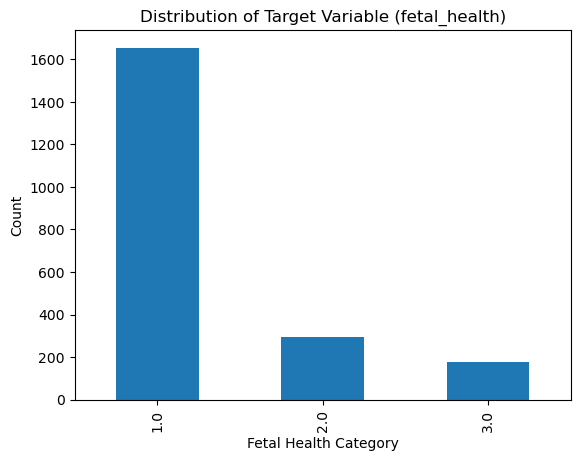

In [43]:
df['fetal_health'].value_counts().plot(kind='bar', title='Distribution of Target Variable (fetal_health)')
plt.xlabel('Fetal Health Category')
plt.ylabel('Count')
plt.show()

### 2.2 Feature Scaling

In [44]:
from joblib import dump
X = df.drop(columns=['fetal_health'])
y = df['fetal_health']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X, columns=X.columns)
X_scaled_df.head()

# Save the scaler to a file
dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Step 3: Feature Selection
### 3.1 Correlation Analysis

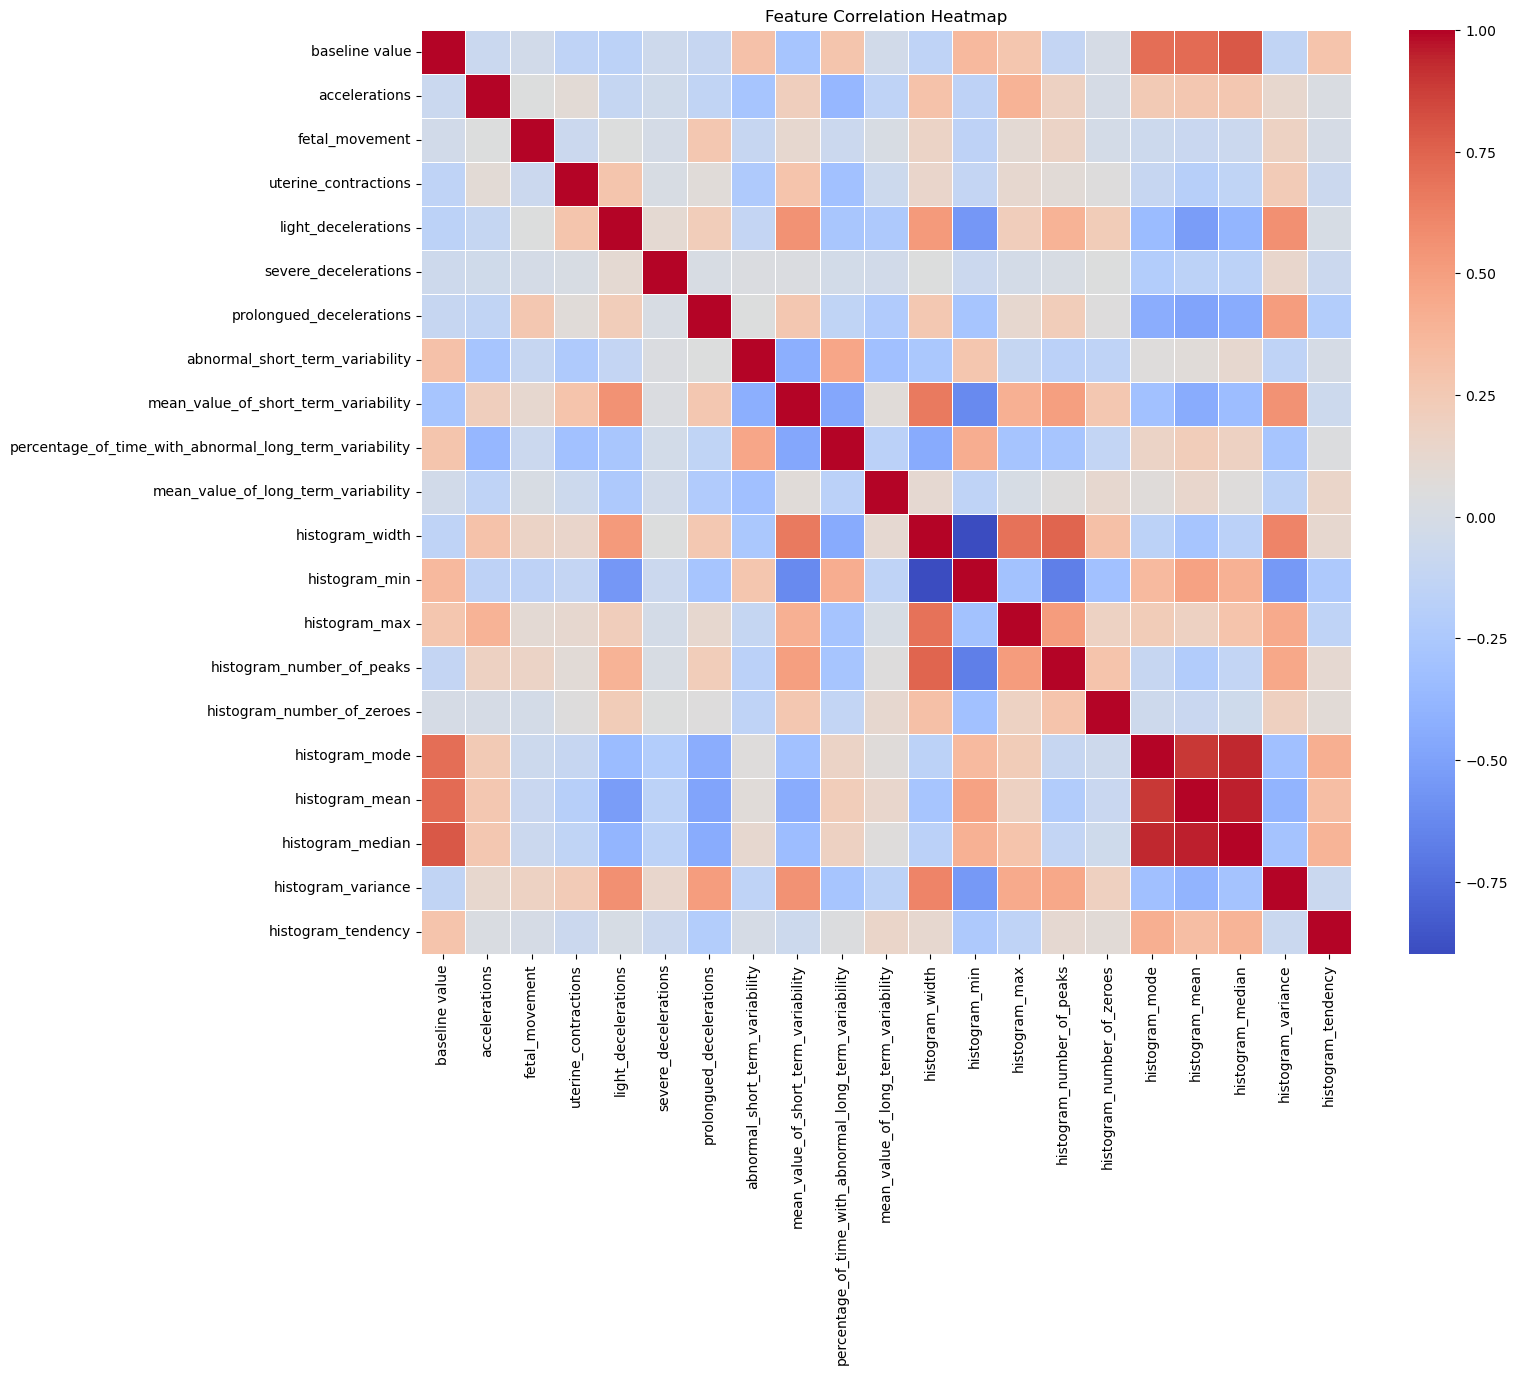

In [45]:
correlation_matrix = X_scaled_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [46]:
high_corr_features = [(col, row) for col in correlation_matrix.columns for row in correlation_matrix.index if col != row and abs(correlation_matrix.loc[row, col]) > 0.85]
high_corr_features

[('histogram_width', 'histogram_min'),
 ('histogram_min', 'histogram_width'),
 ('histogram_mode', 'histogram_mean'),
 ('histogram_mode', 'histogram_median'),
 ('histogram_mean', 'histogram_mode'),
 ('histogram_mean', 'histogram_median'),
 ('histogram_median', 'histogram_mode'),
 ('histogram_median', 'histogram_mean')]

### 3.2 Removing Highly Correlated Features

In [47]:
features_to_drop = ['histogram_min', 'histogram_mode', 'histogram_mean', 'histogram_median']
X_reduced = X_scaled_df.drop(columns=features_to_drop)

### 3.3 Feature Importance using Random Forest

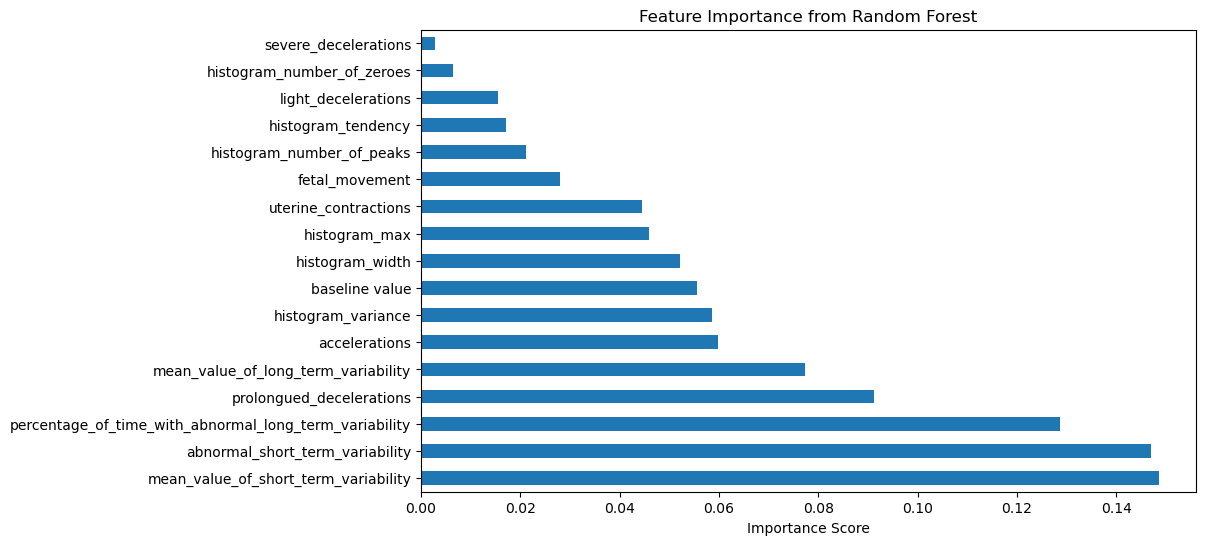

mean_value_of_short_term_variability                      0.148611
abnormal_short_term_variability                           0.146907
percentage_of_time_with_abnormal_long_term_variability    0.128651
prolongued_decelerations                                  0.091171
mean_value_of_long_term_variability                       0.077290
dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42, stratify=y)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_reduced.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh', title='Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.show()
feature_importances.head()

## Step 4: Model Training and Evaluation

In [49]:
selected_features = feature_importances.head(10).index
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [50]:
print(X_train_selected)

      mean_value_of_short_term_variability  abnormal_short_term_variability  \
480                                    0.8                             60.0   
123                                    1.3                             33.0   
1099                                   1.8                             22.0   
1804                                   0.3                             68.0   
381                                    1.1                             41.0   
...                                    ...                              ...   
358                                    0.5                             60.0   
1926                                   1.2                             63.0   
250                                    0.5                             61.0   
1449                                   1.2                             36.0   
229                                    0.8                             52.0   

      percentage_of_time_with_abnormal_long_term_va

In [51]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Adding Decision Tree and K-Nearest Neighbors (KNN) to the list of models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


results = []
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    results.append({'Model': model_name, 'Accuracy': accuracy_score(y_test, y_pred), 'Precision': precision_score(y_test, y_pred, average='weighted'), 'Recall': recall_score(y_test, y_pred, average='weighted'), 'F1 Score': f1_score(y_test, y_pred, average='weighted')})
results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False)

C:\Users\sdhar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest,0.921630,0.918392,0.921630,0.919242
3,Gradient Boosting,0.918495,0.915097,0.918495,0.915569
4,Decision Tree,0.909091,0.905752,0.909091,0.906419
5,K-Nearest Neighbors,0.884013,0.879731,0.884013,0.880362
0,Logistic Regression,0.849530,0.843489,0.849530,0.838366
1,Support Vector Machine,0.833856,0.831100,0.833856,0.808894


In [52]:
# Fitting the Random Forest model again to ensure completeness
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_selected, y_train)  # Fitting the model with selected training data

# Dumping the trained Random Forest model using joblib
joblib.dump(random_forest_model, 'random_forest_model.joblib')  # Saving the model as 'random_forest_model.joblib'


['random_forest_model.joblib']

### Displaying Evaluation Results

In [53]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.849530,0.843489,0.849530,0.838366
1,Support Vector Machine,0.833856,0.831100,0.833856,0.808894
2,Random Forest,0.921630,0.918392,0.921630,0.919242
3,Gradient Boosting,0.918495,0.915097,0.918495,0.915569
4,Decision Tree,0.909091,0.905752,0.909091,0.906419
5,K-Nearest Neighbors,0.884013,0.879731,0.884013,0.880362
